In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def calculate_eddy(width=500000, num_depth_layers=21, eta0=1, L=1e5, H=1000, a=1, b=1, rho0=1025, 
                                            f0=None, alpha_1=0.01, alpha_2=0.01, T0=20, dTdz=0.005, dSdz=0.01, taper_depth=None):
    """
    Calculate the 3D geostrophic velocity components U, V, density anomaly sigma, temperature, salinity, 
    and pressure fields for an ocean eddy.

    Parameters:
    - width: Horizontal extent of the grid (eddy scale) in meters.
    - num_depth_layers: Number of vertical layers (depth resolution).
    - eta0: Surface elevation perturbation.
    - L: Horizontal length scale of the eddy in meters.
    - H: Vertical depth scale of the eddy in meters.
    - a, b: Coefficients affecting density anomaly variation.
    - rho0: Reference density (kg/m^3).
    - f0: Coriolis parameter. If None, it will be calculated based on a latitude of -34 degrees.
    - alpha_1, alpha_2: Coefficients affecting eddy center shift with depth.
    - T0: Surface temperature (degrees Celsius).
    - dTdz: Temperature gradient with depth (degrees Celsius per meter).
    - dSdz: Salinity gradient with depth (psu per meter).
    - taper_depth: Tapering scale for vertical variations.

    Returns:
    - U, V: 3D matrices for the U and V (x- and y-components) velocity fields.
    - sigma: 3D matrix for the density anomaly.
    - T: 3D matrix for the temperature field.
    - S: 3D matrix for the salinity field.
    - P: 3D matrix for the pressure field.
    - x, y, z: Horizontal and vertical grid points.
    """

    # Constants
    if f0 is None:
        f0 = 2 * 7.29E-5 * np.sin(np.radians(-34))  # Coriolis parameter for latitude -34 degrees
    g = 9.81  # Gravitational acceleration (m/s^2)

    # Create 2D meshgrid for horizontal space (x, y) and depth (z)
    x = np.linspace(-width // 2, width // 2, 101)  # x-coordinates
    y = np.linspace(-width // 2, width // 2, 101)  # y-coordinates
    z = np.linspace(-H, 0, num_depth_layers)  # Depth levels from surface (0) to -H

    # Create 3D meshgrid
    x_3d, y_3d, z_3d = np.meshgrid(x, y, z, indexing='ij')

    if taper_depth is None:
        taper_factor = np.ones_like(z_3d)
    else:
        taper_factor = np.exp(z_3d / taper_depth)

    # Define the functions f(|r - r_c(z)|) and g(z)
    def f_r_rc(r, L):
        return np.exp(-r**2 / L**2)

    # Calculate the center position as a function of depth
    x_c = alpha_1 * z_3d
    y_c = alpha_2 * z_3d

    # Calculate radial distance r - r_c(z)
    r_c = np.hypot( x_3d - x_c, y_3d - y_c )

    # Temperature field
    # T = T0 + dTdz * z_3d - 2 * f_r_rc(r_c, L) * taper_factor
    T = - 2 * f_r_rc(r_c, L) * taper_factor

    # Salinity field
    S0 = 35  # Reference surface salinity (psu)
    # S = S0 + dSdz * z_3d + 1.5 * f_r_rc(r_c, L) * taper_factor
    S = 1.5 * f_r_rc(r_c, L) * taper_factor

    # Pressure field (hydrostatic pressure)
    P = -rho0 * g * z_3d

    # Density field using a simplified equation of state
    alpha = 0.0002  # Thermal expansion coefficient (1/°C)
    beta = 0.0008  # Haline contraction coefficient (1/psu)
    sigma = rho0 * (1 - alpha * (T - T0) + beta * (S - S0)) 
    sigma -= np.mean(sigma)

    # Calculate geostrophic velocity components
    dx = x[1] - x[0]  # Grid spacing in x
    dy = y[1] - y[0]  # Grid spacing in y
    d_sigma_dx = np.gradient(sigma, axis=0) / dx
    d_sigma_dy = np.gradient(sigma, axis=1) / dy

    U = g / f0 * d_sigma_dy * taper_factor
    V = -g / f0 * d_sigma_dx * taper_factor

    U = np.flip(U, axis=2)
    V = np.flip(V, axis=2)
    sigma = np.flip(sigma, axis=2)
    T = np.flip(T, axis=2)
    S = np.flip(S, axis=2)
    P = np.flip(P, axis=2)
    z = np.flip(z)

    return U, V, sigma, T, S, P, x/1000, y/1000, z


In [86]:
def moca(u1, v1, u2, v2, n_ic, n_jc, dx):

    def domain_finder(lst, ic, cyc, vel_vec):
        def find_local_extrema(data):
            minima = [i for i in range(1, len(data) - 1) if data[i - 1] > data[i] < data[i + 1]]
            maxima = [i for i in range(1, len(data) - 1) if data[i - 1] < data[i] > data[i + 1]]
            return np.array(minima), np.array(maxima)
    
        minima, maxima = find_local_extrema(lst)
        minima = np.array([m for m in minima if lst[m] <= 0])
        maxima = np.array([m for m in maxima if lst[m] >= 0])
    
        condition = (cyc == 'CE' and vel_vec == 'v') or (cyc == 'AE' and vel_vec == 'u')
        valid_maxima = maxima[maxima <= ic] if condition else maxima[maxima >= ic]
        valid_minima = minima[minima >= ic] if condition else minima[minima <= ic]
    
        domain_max = valid_maxima[np.argmin(np.abs(valid_maxima - ic))]
        domain_min = valid_minima[np.argmin(np.abs(valid_minima - ic))]
    
        start, end = sorted((domain_min, domain_max))
        indices = np.arange(start, end + 1)
    
        return np.array(lst[start:end + 1]), indices
        
    u2, u_ind = domain_finder(u2, n_jc, cyc='CE', vel_vec='u')
    v2 = v2[u_ind]

    yy = (np.array(u_ind) - n_jc) * dx

    v1, v_ind = domain_finder(v1, n_ic, cyc='CE', vel_vec='v')
    u1 = u1[v_ind]
    xx = (np.array(v_ind) - n_ic) * dx

    def polynomial_fit_with_error(x, y, degree=1):
        mask = ~np.isnan(x) & ~np.isnan(y)
        x, y = x[mask], y[mask]
        if degree not in [0, 1]:
            raise ValueError("Degree must be 0 or 1.")
        coefficients, cov = np.polyfit(x, y, degree, cov=True)  # coefficients = [slope, intercept]
        y_fit = np.polyval(coefficients, x)
        residuals = y - y_fit
        std_err_coeffs = np.sqrt(np.diag(cov))
        ss_total = np.sum((y - np.mean(y))**2)
        ss_residuals = np.sum(residuals**2)
        r_squared = 1 - (ss_residuals / ss_total)
        return coefficients, std_err_coeffs, r_squared

    As, dAs, r2A = polynomial_fit_with_error(xx, u1, degree=1)
    A1, A0 = As
    Bs, dBs, r2B = polynomial_fit_with_error(xx, v1, degree=1)
    B1, B0 = Bs
    Cs, dCs, r2C = polynomial_fit_with_error(yy, u2, degree=1)
    C1, C0 = Cs
    Ds, DAs, r2D = polynomial_fit_with_error(yy, v2, degree=1)
    D1, D0 = Ds
    alpha = A0 if r2A < r2B else C0
    beta = B0 if r2B < r2D else D0
    gamma = A1 if r2A < r2D else -D1
    q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2
    Q = np.array([[q11, q12], [q12, q22]])
    
    def is_pos_def(Q):
        eigenvalues = np.linalg.eigvals(Q)
        return np.all(eigenvalues > 0)
    if is_pos_def(Q) or is_pos_def(-Q):
        yc = (q11 * alpha + q12 * beta) / (2 * (q11 * q22 - q12 ** 2))  
        xc = (alpha * q12 + beta * q22) / (2 * (q12 ** 2 - q11 * q22))      
        w = 2 * (q11 + q22)
    else:
        xc = yc = np.nan

    return xc, yc, xx, yy, w, u1, v1, u2, v2

In [100]:
U, V, sigma, T, S, P, x, y, z = calculate_eddy(taper_depth=None)
dx = x[1] - x[0]
u = U[:,:,0]
v = V[:,:,0]

n_ic = 44
n_jc = 44

n_xc = x[n_ic]
n_yc = y[n_jc]

u1 = u[:, n_jc].squeeze()
v1 = v[:, n_jc].squeeze()

u2 = u[n_ic, :].squeeze()
v2 = v[n_ic, :].squeeze()

xc, yc, xx, yy, w, u1, v1, u2, v2 = moca(u1, v1, u2, v2, n_ic, n_jc, dx)

x0 = xc + n_xc
y0 = yc + n_yc

Text(0, 0.5, 'y (km)')

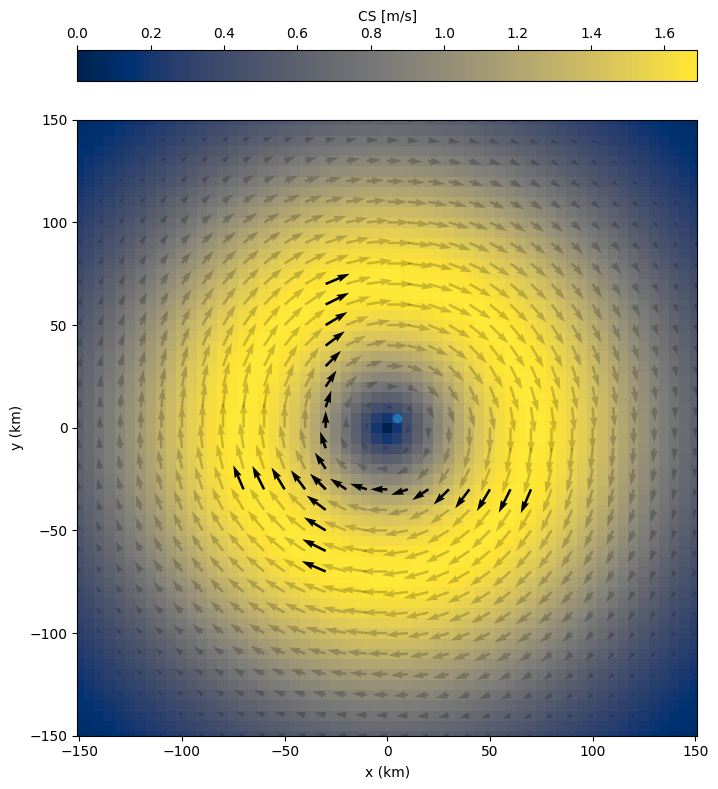

In [101]:
plt.figure(figsize=(8,10))

plt.pcolor(x, y, np.hypot(u, v), cmap='cividis')
plt.colorbar(orientation='horizontal', location='top', label='CS [m/s]')

spacing = 2
scale = 40
width = 0.004

plt.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.2, scale=scale, width=width)

plt.quiver(xx[::spacing] + n_xc, [n_yc] * len(xx[::spacing]),
          u1[::spacing], v1[::spacing], scale=scale, width=width)
plt.quiver([n_xc] * len(yy[::spacing]), yy[::spacing] + n_yc,
          u2[::spacing], v2[::spacing], scale=scale, width=width)

plt.scatter(x0, y0)

plt.axis('equal')
# plt.legend()

plt.xlim(-150, 150)
plt.ylim(-150, 150)

plt.xlabel('x (km)')
plt.ylabel('y (km)')

True

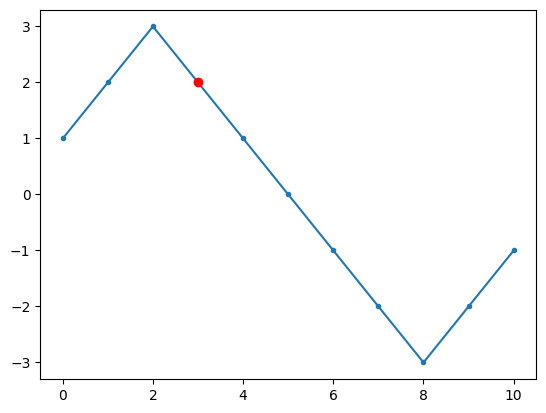

In [56]:
lst = [1, 2, 3, 2, 1, 0, -1, -2, -3, -2, -1]

plt.plot(lst, marker='.')

plt.scatter(3, 2, color='r', zorder=3)

ind = 3

lst[ind-1]*lst[ind+1] > 0

In [85]:

def domain_finder(lst, ic, cyc, vel_vec):
    def find_local_extrema(data):
        minima = [i for i in range(1, len(data) - 1) if data[i - 1] > data[i] < data[i + 1]]
        maxima = [i for i in range(1, len(data) - 1) if data[i - 1] < data[i] > data[i + 1]]
        return np.array(minima), np.array(maxima)

    minima, maxima = find_local_extrema(lst)
    minima = np.array([m for m in minima if lst[m] <= 0])
    maxima = np.array([m for m in maxima if lst[m] >= 0])

    condition = (cyc == 'CE' and vel_vec == 'v') or (cyc == 'AE' and vel_vec == 'u')
    valid_maxima = maxima[maxima <= ic] if condition else maxima[maxima >= ic]
    valid_minima = minima[minima >= ic] if condition else minima[minima <= ic]

    domain_max = valid_maxima[np.argmin(np.abs(valid_maxima - ic))]
    domain_min = valid_minima[np.argmin(np.abs(valid_minima - ic))]

    start, end = sorted((domain_min, domain_max))
    indices = np.arange(start, end + 1)

    return np.array(lst[start:end + 1]), indices




    
domain_finder(lst, ind, cyc='CE', vel_vec='v')

(array([ 3,  2,  1,  0, -1, -2, -3]), array([2, 3, 4, 5, 6, 7, 8]))

In [67]:
lst

[1, 2, 3, 2, 1, 0, -1, -2, -3, -2, -1]

In [174]:
x[ni]

np.float64(-50.0)

In [180]:
ni = 50
nj = 50


u1 = u[:, nj].squeeze()
v1 = v[:, nj].squeeze()

u2 = u[ni, :].squeeze()
v2 = v[ni, :].squeeze()

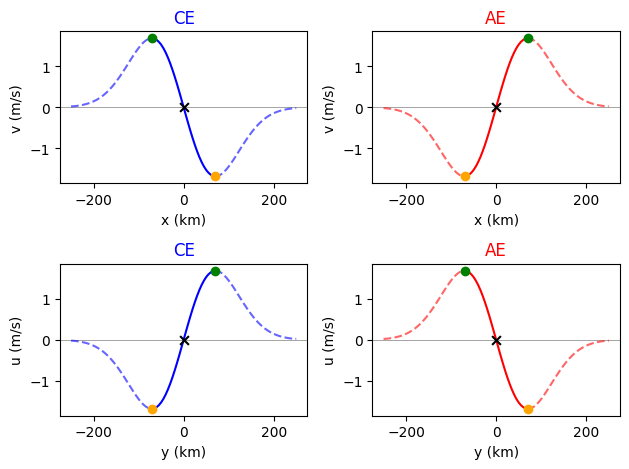

In [185]:
from scipy.signal import argrelextrema

fig, axs = plt.subplots(2, 2)

# Alpha value for transparency
alpha = 0.6

# Identify extrema for v1
v1_max = argrelextrema(v1, np.greater)[0][0]
v1_min = argrelextrema(v1, np.less)[0][0]

# Plot v1
axs[0, 0].plot(x[:v1_max], v1[:v1_max], color='b', zorder=0, alpha=alpha, linestyle='--')
axs[0, 0].plot(x[v1_max:v1_min], v1[v1_max:v1_min], color='b', zorder=0)
axs[0, 0].plot(x[v1_min:], v1[v1_min:], color='b', zorder=0, alpha=alpha, linestyle='--')
axs[0, 0].scatter(x[v1_max], v1[v1_max], color='g')
axs[0, 0].scatter(x[v1_min], v1[v1_min], color='orange')
axs[0, 0].scatter(x[ni], v1[nj], marker='x', s=40, color='k')
axs[0, 0].set_xlabel('x (km)')
axs[0, 0].set_ylabel('v (m/s)')
axs[0, 0].set_title('CE', color='b')

# Identify extrema for u2
u2_max = argrelextrema(u2, np.greater)[0][0]
u2_min = argrelextrema(u2, np.less)[0][0]

# Plot u2
axs[1, 0].plot(y[:u2_min], u2[:u2_min], color='b', zorder=0, alpha=alpha, linestyle='--')
axs[1, 0].plot(y[u2_min:u2_max], u2[u2_min:u2_max], color='b', zorder=0)
axs[1, 0].plot(y[u2_max:], u2[u2_max:], color='b', zorder=0, alpha=alpha, linestyle='--')
axs[1, 0].scatter(y[u2_max], u2[u2_max], color='g')
axs[1, 0].scatter(y[u2_min], u2[u2_min], color='orange')
axs[1, 0].scatter(y[nj], u2[nj], marker='x', s=40, color='k')
axs[1, 0].set_xlabel('y (km)')
axs[1, 0].set_ylabel('u (m/s)')
axs[1, 0].set_title('CE', color='b')

# Identify extrema for flipped v1
flipped_v1 = np.flip(v1)
flipped_v1_max = argrelextrema(flipped_v1, np.greater)[0][0]
flipped_v1_min = argrelextrema(flipped_v1, np.less)[0][0]

# Plot flipped v1
axs[0, 1].plot(x[:flipped_v1_min], flipped_v1[:flipped_v1_min], color='r', zorder=0, alpha=alpha, linestyle='--')
axs[0, 1].plot(x[flipped_v1_min:flipped_v1_max], flipped_v1[flipped_v1_min:flipped_v1_max], color='r', zorder=0)
axs[0, 1].plot(x[flipped_v1_max:], flipped_v1[flipped_v1_max:], color='r', zorder=0, alpha=alpha, linestyle='--')
axs[0, 1].scatter(x[flipped_v1_max], flipped_v1[flipped_v1_max], color='g')
axs[0, 1].scatter(x[flipped_v1_min], flipped_v1[flipped_v1_min], color='orange')
axs[0, 1].scatter(x[ni], flipped_v1[ni], marker='x', s=40, color='k')
axs[0, 1].set_xlabel('x (km)')
axs[0, 1].set_ylabel('v (m/s)')
axs[0, 1].set_title('AE', color='r')

# Identify extrema for flipped u2
flipped_u2 = np.flip(u2)
flipped_u2_max = argrelextrema(flipped_u2, np.greater)[0][0]
flipped_u2_min = argrelextrema(flipped_u2, np.less)[0][0]

# Plot flipped u2
axs[1, 1].plot(y[:flipped_u2_max], flipped_u2[:flipped_u2_max], color='r', zorder=0, alpha=alpha, linestyle='--')
axs[1, 1].plot(y[flipped_u2_max:flipped_u2_min], flipped_u2[flipped_u2_max:flipped_u2_min], color='r', zorder=0)
axs[1, 1].plot(y[flipped_u2_min:], flipped_u2[flipped_u2_min:], color='r', zorder=0, alpha=alpha, linestyle='--')
axs[1, 1].scatter(y[flipped_u2_max], flipped_u2[flipped_u2_max], color='g')
axs[1, 1].scatter(y[flipped_u2_min], flipped_u2[flipped_u2_min], color='orange')
axs[1, 1].scatter(y[nj], flipped_u2[nj], marker='x', s=40, color='k')
axs[1, 1].set_xlabel('y (km)')
axs[1, 1].set_ylabel('u (m/s)')
axs[1, 1].set_title('AE', color='r')

for ax in axs.flatten():
    ax.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)

plt.tight_layout()
plt.show()


Text(0, 0.5, 'y (km)')

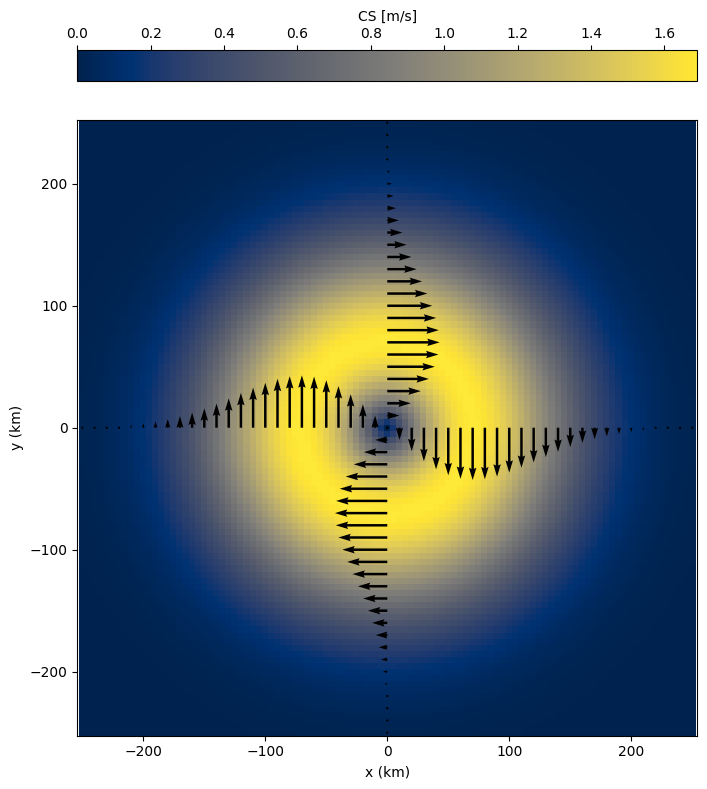

In [169]:
plt.figure(figsize=(8,10))

plt.pcolor(x, y, np.hypot(u, v), cmap='cividis')
plt.colorbar(orientation='horizontal', location='top', label='CS [m/s]')

spacing = 2
scale = 20
width = 0.004

# plt.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, alpha=.2, scale=scale, width=width)

plt.quiver([0]*len(y[::spacing]), y[::spacing], u2[::spacing], [0]*len(u2[::spacing]), scale=scale, width=width)

plt.quiver(x[::spacing], [0]*len(x[::spacing]), [0]*len(v1[::spacing]), v1[::spacing], scale=scale, width=width)

plt.axis('equal')
# plt.legend()

# plt.xlim(-150, 150)
# plt.ylim(-150, 150)

plt.xlabel('x (km)')
plt.ylabel('y (km)')